In [1]:
# Notebook with supplementary Figures 1 and 2 

In [2]:
%pylab
%matplotlib inline
%reload_ext autoreload
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import pandas as pd
import sys
import seaborn as sns
sys.path.append('../../src')
import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('../..','results',str(date.today()))

if not os.path.exists(savefolder):
    os.makedirs(savefolder)

from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=35
fontSize = 54
import matplotlib.gridspec as gridspec


Using matplotlib backend: <object object at 0x106ca6450>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Feature importance plot

In [4]:
def makeFigureErrorBar(h1,h2,out,title,thresholds = None,fig=None,axs=None,linecolor = 'k',err=None):
    """
    Make a figure ov average ABR traces with sd error bars.
    Parameters:
    h1 (list or array-like): List of frequencies.
    h2 (list or array-like): List of intensities.
    out (array-like): Data to plot.
    title (str): Title of the figure.
    thresholds (dict, optional): Dictionary of threshold values for each frequency. Default is None.
    fig (matplotlib.figure.Figure, optional): Figure object to use for plotting. Default is None.
    axs (array-like of matplotlib.axes.Axes, optional): Axes object to use for plotting. Default is None.
    linecolor (str, optional): Color of the lines. Default is 'k' (black).
    err (array-like, optional): Error data to plot as shaded regions. Default is None.
    Returns:
    tuple: A tuple containing the figure and axes objects (fig, axs).
    """

    frequency = list(set(h1))#[100,3000,6000, 12000,18000,24000,30000,36000,42000 ]
    frequency.sort()
    intensity = list(set(h2))#arange(0,100,5)
    intensity.sort()
    nint = len(intensity)
    nfreq=len(frequency)
    freqmap=dict(zip(frequency,np.arange(len(frequency))))
    imap = dict(zip(intensity,np.arange(len(intensity))))
    if nint==1:
        nint=2
    if nfreq==1:
        nfreq=2
    if fig is None:
        fig,axs=plt.subplots(nint,nfreq,sharex=False, sharey=False,subplot_kw={'xticks': [], 'yticks': []},figsize=np.array([ 15.8 ,  16.35]))
    for i in range(len(h1)):
        column = freqmap[int(h1[i])]
        row = imap[int(h2[i])]
        #plotn = i+row*len(frequency)
        linecol = linecolor
        if thresholds is not None:
            if h2[i]>=thresholds[h1[i]]:
                linecol = 'r'
            else:
                linecol = linecolor
        if int(h2[i])>=15:
            axs[nint-row-1,column].plot(np.array(out)[i,:],c=linecol,linewidth=2)

            if err is not None:
                axs[nint-row-1,column].fill_between(arange(out.shape[1]),np.array(out)[i,:]-np.array(err)[i,:],np.array(out)[i,:]+np.array(err)[i,:],
                                                    alpha=0.15,color = linecol)
        #axs[nint-row-1,column].set_ylim((array(out).min(),array(out).max()))
        if nint-row-1==0:
            tit1 = int(h1[i])

            if tit1 == 100:
                tit='Click'
            else:
                tit = str(int(tit1/1000))+' kHz'
            axs[nint-row-1,column].set_title(tit,fontsize=28,ha='center')
        
        if column==0:
            axs[nint-row-1,column].set_ylabel(str(int(h2[i]))+' dB')
    fig.suptitle(title, fontsize=22, fontweight='bold')
    
    plt.tight_layout()
    return fig,axs

def plotFeatureImportance(fi,abr=None,savgolOrder = 51,ylims=(-5.5,10)):
    if abr == None:
        abr = at.extractABR('../../data/20220520/Mouse #1-[226251-LE].csv')

    fi = savgol_filter(fi,savgolOrder,1)
    ntraces = 153
    ppt = 1953#int(fi.size/ntraces)

    
    fig,_ = makeFigure(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,title='')
    for column in range(9):
        for row in range(17):
            tr = fi[(16-row+column*17)*ppt:(16-row+1)*ppt + column*17*ppt]
            currAx = row*9 + column
            ax2 = fig.axes[currAx].twinx()
            ax2.plot(tr*100000/2-5,'r',linewidth=2.5)

    for i in range(180,333):
        ax = fig.axes[i]
        ax.set_ylim(ylims[0],ylims[1])
        ax.axis('off')

    for i in range(0,180):
        ax = fig.axes[i]
        ax.set_ylim(-4.5,5.5)
        ax.axis('off')
        ax.set_xlim(0,9*fs/1000)

    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=0.05,hspace=0,left=1)
    #tight_layout()
    fig.show()




In [5]:
frequencies = ['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz',
       '30 kHz', '36 kHz', '42 kHz']

fs = 195000.0/2.0 # Acquisition sampling rate

data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
thresholds['ID'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[0].astype(int)
thresholds['Age (months)'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[1].str.split('month',expand=True)[0].astype(int)
strain = []
for el in thresholds['ID']:
    strain.append(data.loc[data['ID']==el,'Strain'].values[0])
thresholds['Strain'] = strain

The dataset version is: 20230914 - V41


In [6]:
def generateAbrComparisonFigure(folderN=1):
    """
    Generates a comparison figure of average ABR (Auditory Brainstem Response) traces for two strains: '6N' and 'Repaired'.

    Parameters:
    folderN (int): The folder number to use for extracting ABR data. Default is 1 (1month)

    Returns:
    matplotlib.figure.Figure: The generated figure with ABR comparison plots.

    """

    abr6N = []
    abrRep = []
    for i,el in data.iterrows():
        strain = el['Strain']
        if not pd.isna(el[f'Folder {folderN}']):
            folder = os.path.join('../../data',el[f'Folder {folderN}'][2:])
            abr = at.extractABR(folder)
            if strain =='6N':
                abr6N.append(abr)
            elif strain =='Repaired':
                abrRep.append(abr)

    ntraces = 153
    ppt = 1953#int(fi.size/ntraces)

    abr = pd.concat(abr6N).reset_index().groupby(['level_0','level_1']).mean()
    abrerr = pd.concat(abr6N).reset_index().groupby(['level_0','level_1']).std()

    fig,axs = makeFigureErrorBar(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,title='',err=abrerr,linecolor='#DC3220')

    abr = pd.concat(abrRep).reset_index().groupby(['level_0','level_1']).mean()
    abrerr = pd.concat(abrRep).reset_index().groupby(['level_0','level_1']).std()

    fig,axs = makeFigureErrorBar(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,title='',fig=fig,axs=axs,linecolor='#005AB5',err=abrerr)


    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=0.05,hspace=0,left=+.035)


    for i in range(0,180):
        ax = fig.axes[i]
    # ax.set_ylim(-4.5,5.5)
        ax.axis('off')
        ax.set_xlim(0,10*fs/1000)

    fig.text(0.08, 0.1,  
            '6N',  

            fontsize = 32, 
            color = "#DC3220") 

    fig.text(0.15, 0.1,  
            '6N-Repaired',  

            fontsize = 32, 
            color = "#005AB5") 
    return fig
    #fig.suptitle('1 month',fontsize=fontSize)

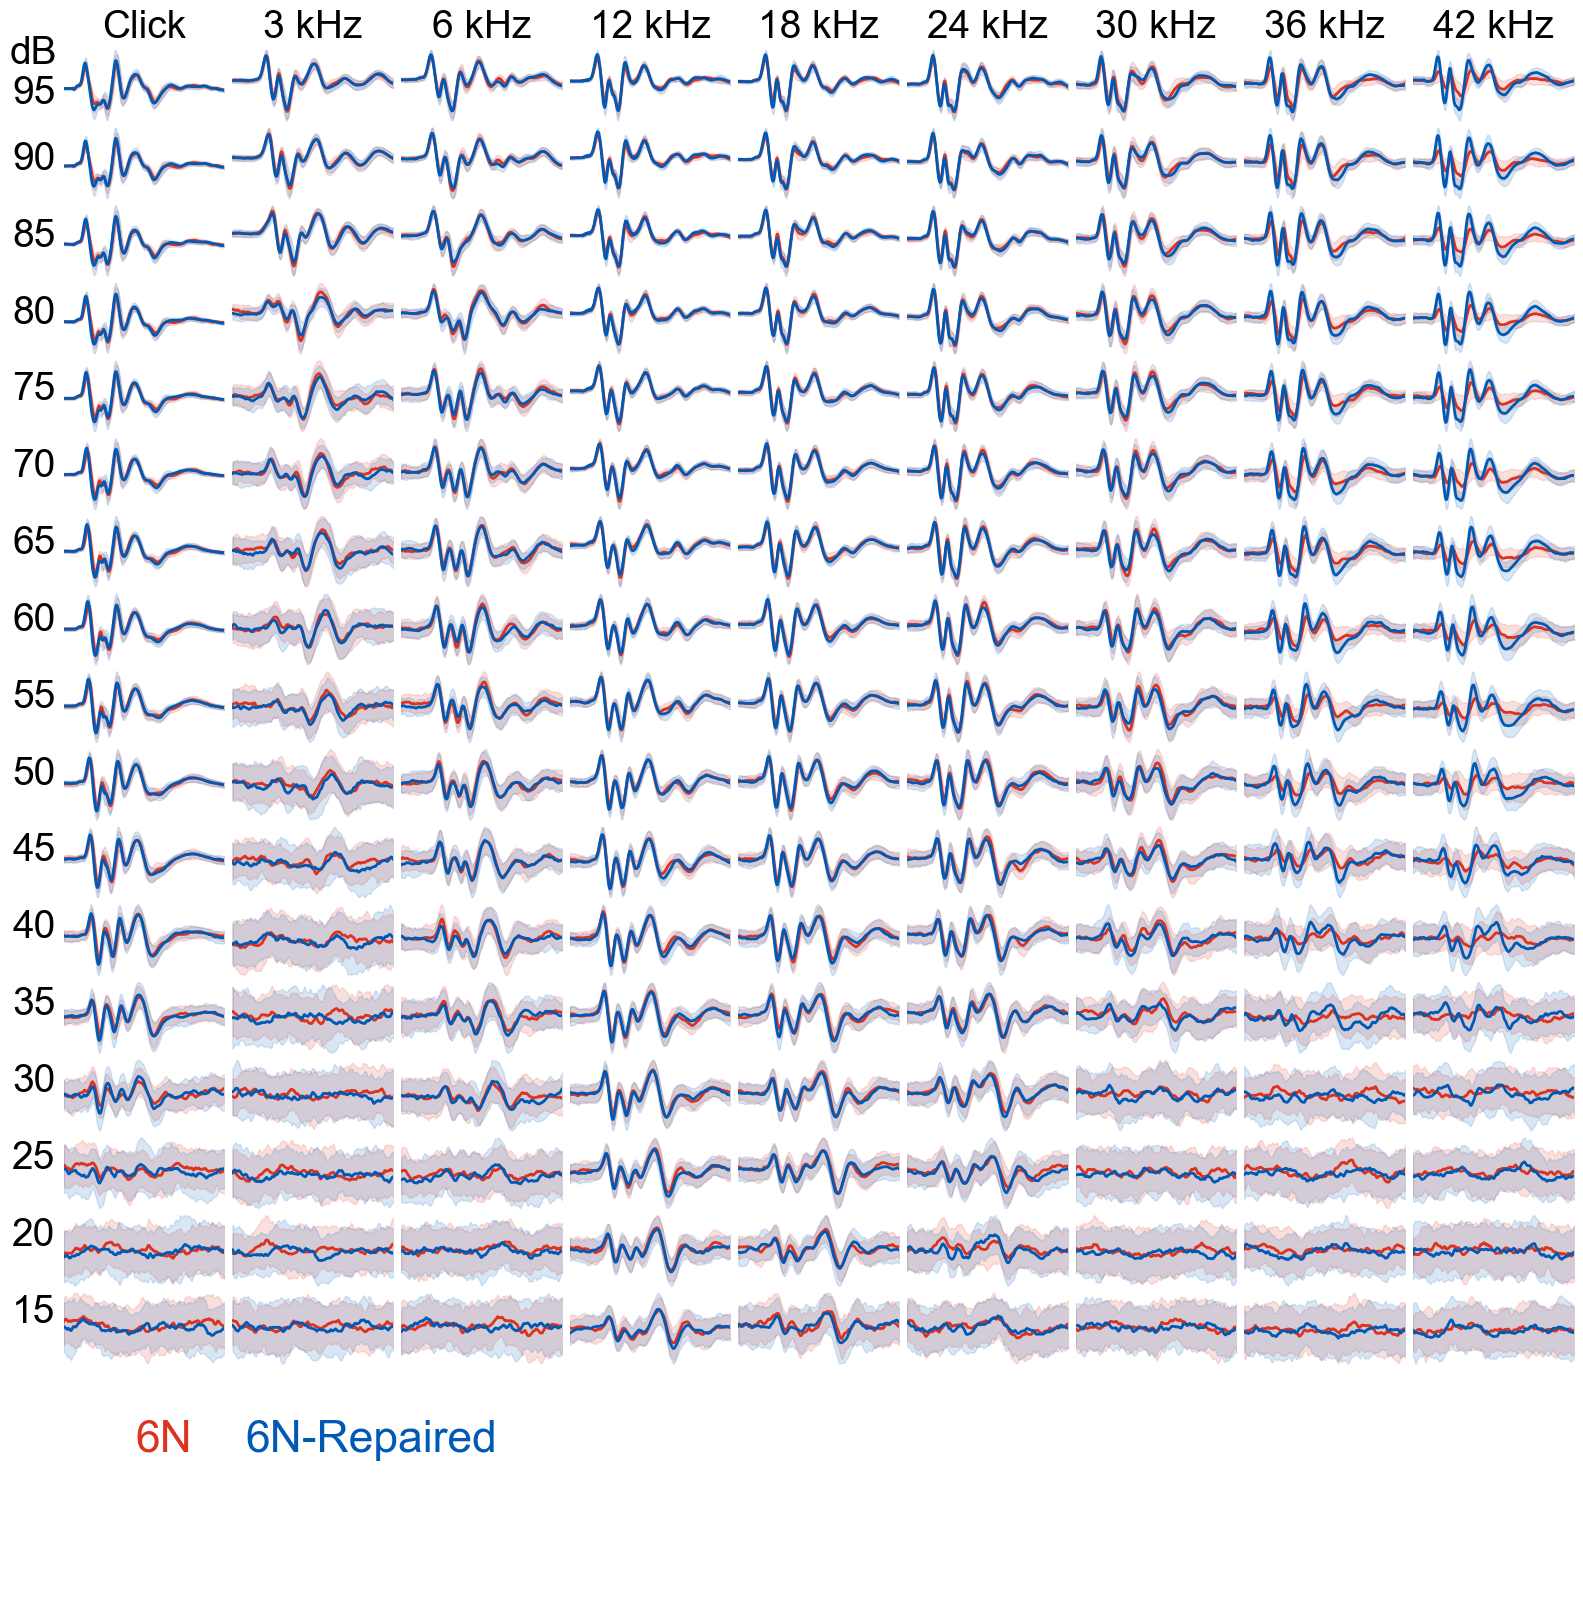

In [ ]:
import abrTools as at

# 1 month old (Supp figure 1)
f = generateAbrComparisonFigure(1)

f.text(0.016,0.93,'95',fontsize=28, rotation = 0,va='center',ha='center')
f.text(0.016,0.955,'dB',fontsize=28, rotation = 0,va='center',ha='center')
for i in range(16):
    f.text(0.016,0.185+i*0.047,f'{15+5*i}',fontsize=28, rotation = 0,va='center',ha='center')


f.savefig('./Panels/averageABR1month.pdf',transparent=True,dpi=1200)


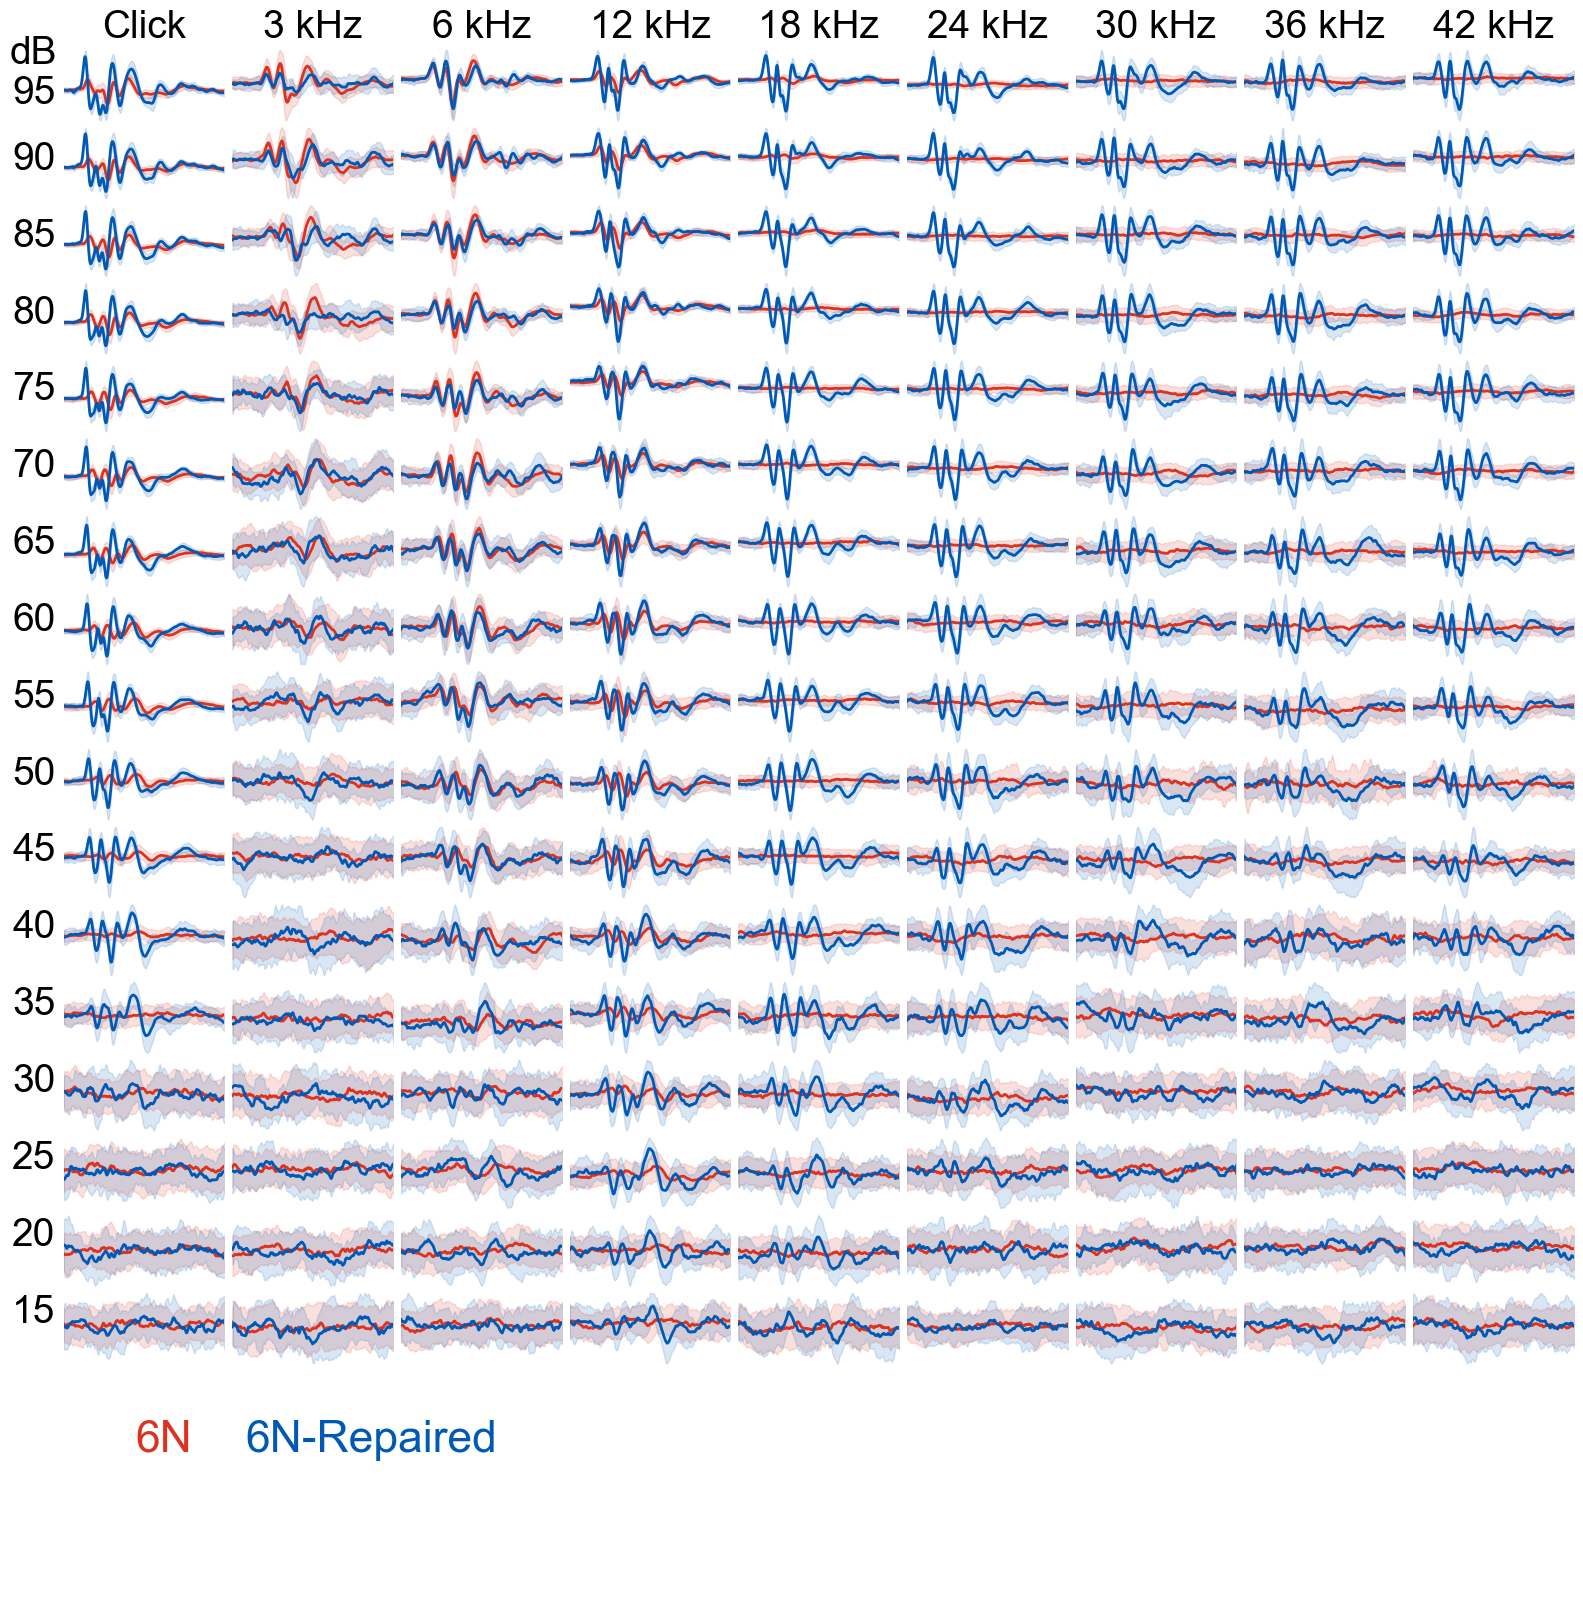

In [8]:
#12 months (Supp fig 2)
f= generateAbrComparisonFigure(5)
f.text(0.016,0.93,'95',fontsize=28, rotation = 0,va='center',ha='center')
f.text(0.016,0.955,'dB',fontsize=28, rotation = 0,va='center',ha='center')
for i in range(16):
    f.text(0.016,0.185+i*0.047,f'{15+5*i}',fontsize=28, rotation = 0,va='center',ha='center')
savefig('./Panels/averageABR12month.pdf',transparent=True,dpi=1200)